In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import optuna
import warnings

warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

In [ ]:
train_df.shape

(80000, 4)

In [ ]:
print(train_df.head())

      id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   
3  66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4   2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label  
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  
1  [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0  
2  [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...    0.0  
3  [-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...    0.0  
4  [1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...    0.0  


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [ ]:
print(train_df.describe())

                 id         label
count  80000.000000  80000.000000
mean   50107.893162      0.277250
std    28857.649778      0.447644
min        0.000000      0.000000
25%    25122.500000      0.000000
50%    50146.500000      0.000000
75%    75064.250000      1.000000
max    99999.000000      1.000000


In [ ]:
train_df['dates'][0]

array([datetime.date(2016, 1, 1), datetime.date(2016, 2, 1),
       datetime.date(2016, 3, 1), datetime.date(2016, 4, 1),
       datetime.date(2016, 5, 1), datetime.date(2016, 6, 1),
       datetime.date(2016, 7, 1), datetime.date(2016, 8, 1),
       datetime.date(2016, 9, 1), datetime.date(2016, 10, 1),
       datetime.date(2016, 11, 1), datetime.date(2016, 12, 1),
       datetime.date(2017, 1, 1), datetime.date(2017, 2, 1),
       datetime.date(2017, 3, 1), datetime.date(2017, 4, 1),
       datetime.date(2017, 5, 1), datetime.date(2017, 6, 1),
       datetime.date(2017, 7, 1), datetime.date(2017, 8, 1),
       datetime.date(2017, 9, 1), datetime.date(2017, 10, 1),
       datetime.date(2017, 11, 1), datetime.date(2017, 12, 1),
       datetime.date(2018, 1, 1), datetime.date(2018, 2, 1),
       datetime.date(2018, 3, 1), datetime.date(2018, 4, 1),
       datetime.date(2018, 5, 1), datetime.date(2018, 6, 1),
       datetime.date(2018, 7, 1), datetime.date(2018, 8, 1),
       datetime.da

id        0
dates     0
values    0
label     0
dtype: int64


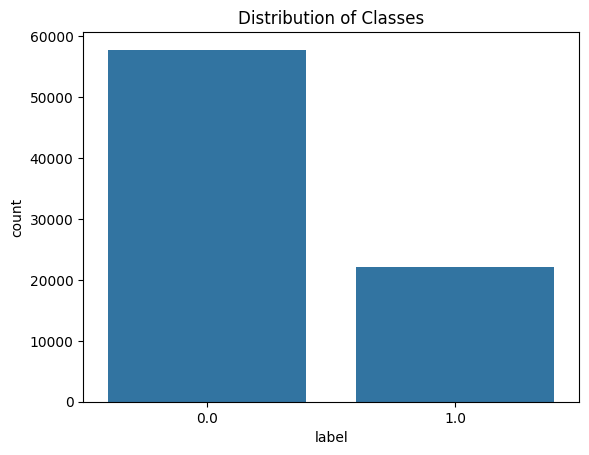

In [ ]:
print(train_df.isnull().sum())

# Визуализация классов
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Classes')
plt.show()

In [ ]:
def create_features(data):
    if 'label' in data:
      df = pd.DataFrame({
          'id': data['id'],
          'dates': data['dates'],
          'values': data['values'],
          'label': data['label']
      })
    else:
      df = pd.DataFrame({
          'id': data['id'],
          'dates': data['dates'],
          'values': data['values'],
      })

    # Генерация признаков
    df['mean'] = df['values'].apply(np.mean)
    df['std'] = df['values'].apply(np.std)
    df['min'] = df['values'].apply(np.min)
    df['max'] = df['values'].apply(np.max)
    df['median'] = df['values'].apply(np.median)

    # Скользящие средние
    df['rolling_mean'] = df['values'].apply(lambda x: pd.Series(x).rolling(window=7).mean().iloc[-1])
    df['rolling_std'] = df['values'].apply(lambda x: pd.Series(x).rolling(window=7).std().iloc[-1])

    return df

In [ ]:
train_features = create_features(train_df)
test_features = create_features(test_df)

In [ ]:
X = train_features.drop(columns=['id', 'dates', 'values','label'])
y = train_features['label']

In [ ]:
# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 50, 200),
        'random_strength': trial.suggest_float('random_strength', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 3),
        'eval_metric': 'AUC',
        'logging_level': 'Silent'
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_prob)
    return auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

[I 2024-10-23 19:09:06,044] A new study created in memory with name: no-name-bc376b7c-255f-48f3-a80e-85928553cee7
[I 2024-10-23 19:09:22,128] Trial 0 finished with value: 0.915933485313552 and parameters: {'iterations': 642, 'depth': 9, 'learning_rate': 0.04171626748049838, 'l2_leaf_reg': 6.297777151609679, 'border_count': 98, 'random_strength': 2.39778261679509, 'bagging_temperature': 0.14679675742696988, 'scale_pos_weight': 1.4264489187883367}. Best is trial 0 with value: 0.915933485313552.
[I 2024-10-23 19:09:35,902] Trial 1 finished with value: 0.9149929108214636 and parameters: {'iterations': 852, 'depth': 3, 'learning_rate': 0.07469005246169128, 'l2_leaf_reg': 6.436848463132816, 'border_count': 179, 'random_strength': 2.398111964008082, 'bagging_temperature': 0.8009470635110586, 'scale_pos_weight': 2.265735097079054}. Best is trial 0 with value: 0.915933485313552.
[I 2024-10-23 19:09:45,976] Trial 2 finished with value: 0.9106519049979118 and parameters: {'iterations': 519, 'dept

In [ ]:
best_params = study.best_params
print(f'Best Parameters: {best_params}')

Best Parameters: {'iterations': 999, 'depth': 7, 'learning_rate': 0.03742505844142178, 'l2_leaf_reg': 4.345886608634476, 'border_count': 145, 'random_strength': 8.687965005808255, 'bagging_temperature': 0.3059947038428944, 'scale_pos_weight': 1.5285392190588316}


In [ ]:
cat_model = CatBoostClassifier(**best_params)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

0:	learn: 0.6682024	test: 0.6682458	best: 0.6682458 (0)	total: 23.4ms	remaining: 23.4s
1:	learn: 0.6439820	test: 0.6442161	best: 0.6442161 (1)	total: 43ms	remaining: 21.4s
2:	learn: 0.6277533	test: 0.6279510	best: 0.6279510 (2)	total: 64.9ms	remaining: 21.6s
3:	learn: 0.6093665	test: 0.6094513	best: 0.6094513 (3)	total: 86.1ms	remaining: 21.4s
4:	learn: 0.5916790	test: 0.5918322	best: 0.5918322 (4)	total: 107ms	remaining: 21.2s
5:	learn: 0.5757764	test: 0.5762121	best: 0.5762121 (5)	total: 127ms	remaining: 21s
6:	learn: 0.5604950	test: 0.5610923	best: 0.5610923 (6)	total: 149ms	remaining: 21.2s
7:	learn: 0.5461550	test: 0.5469030	best: 0.5469030 (7)	total: 170ms	remaining: 21.1s
8:	learn: 0.5350649	test: 0.5358409	best: 0.5358409 (8)	total: 190ms	remaining: 20.9s
9:	learn: 0.5250339	test: 0.5257685	best: 0.5257685 (9)	total: 212ms	remaining: 20.9s
10:	learn: 0.5147153	test: 0.5155205	best: 0.5155205 (10)	total: 236ms	remaining: 21.2s
11:	learn: 0.5066990	test: 0.5076157	best: 0.5076157

In [ ]:
y_pred_prob_final = cat_model.predict_proba(X_val)[:, 1]
roc_auc_final = roc_auc_score(y_val, y_pred_prob_final)
print(f'Final ROC-AUC Score: {roc_auc_final:.4f}')

Final ROC-AUC Score: 0.9162


In [ ]:
# Сохраняем лучшую модель
joblib.dump(cat_model, 'best_model.joblib')

['best_model.joblib']